In [1]:
#from Adapt import AdaptVQE_Y

from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
import warnings
from qiskit_nature.circuit.library import HartreeFock,UCCSD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator

from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import AdaptVQE

from qiskit_nature.settings import QiskitNatureSettings
QiskitNatureSettings.dict_aux_operators = True

import numpy as np 
warnings.filterwarnings("ignore")

/tmp/ipykernel_1706/1528283346.py:17: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
/tmp/ipykernel_1706/1528283346.py:17: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory


In [40]:
molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["O", [0.0, 0.0, 0.0]],
        ["H", [0.758602, 0.0, 0.504284]],
        ["H", [0.758602, 0.0, -0.504284]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

#driver = PySCFDriver(atom="O 0 0 0;H 0.758602 0 0.504284;H 0.758602 0 -0.504284",basis="sto-3g")

properties = driver.run()
converter = QubitConverter(JordanWignerMapper())
#PN_property = properties.get_property("ParticleNumber")
#print(PN_property)

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, #how many electrons we have in our active space
    num_molecular_orbitals=2, #how many orbitals we have in our active space
)

problem = ElectronicStructureProblem(driver, [transformer])
second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print('水分子 近似活跃空间优化后：\n轨道数目：{a}\n粒子数目{b}\n'.format(a=num_spin_orbitals,b=num_particles))

水分子 近似活跃空间优化后：
轨道数目：4
粒子数目(1, 1)



In [57]:
ansatz =UCCSD(num_spin_orbitals=num_spin_orbitals,num_particles=num_particles,qubit_converter=converter,initial_state=init_state)
ansatz.excitation_list  #[((0,), (1,)), ((2,), (3,)), ((0, 2), (1, 3))]
ansatz.excitations #'sd'

'sd'

### Excitation generator utilities

In [53]:
from qiskit_nature.second_q.circuit.library.ansatzes.utils import generate_fermionic_excitations
print('num_spin_orbitals={0} num_particles={1}'.format(num_spin_orbitals,num_particles))
ex_op1 = generate_fermionic_excitations(num_excitations=1, num_spatial_orbitals=4, num_particles=num_particles)
ex_op2 = generate_fermionic_excitations(num_excitations=2, num_spatial_orbitals=4, num_particles=num_particles)

num_spin_orbitals=4 num_particles=(1, 1)


In [55]:
ex_op2

[((0, 4), (1, 5)),
 ((0, 4), (1, 6)),
 ((0, 4), (1, 7)),
 ((0, 4), (2, 5)),
 ((0, 4), (2, 6)),
 ((0, 4), (2, 7)),
 ((0, 4), (3, 5)),
 ((0, 4), (3, 6)),
 ((0, 4), (3, 7))]

In [56]:
ex_op1

[((0,), (1,)),
 ((0,), (2,)),
 ((0,), (3,)),
 ((4,), (5,)),
 ((4,), (6,)),
 ((4,), (7,))]

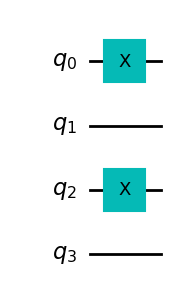

In [49]:
init_state.draw('mpl')

In [60]:
from qiskit_nature.second_q.operators import FermionicOp 
operators = []
excitations = ex_op1

for exc in excitations:
    label = []
    for occ in exc[0]:
        label.append(f"+_{occ}")
    for unocc in exc[1]:
        label.append(f"-_{unocc}")
    op = FermionicOp({" ".join(label): 1}, num_spin_orbitals=8)
    op -= op.adjoint()
            # we need to account for an additional imaginary phase in the exponent (see also
            # `PauliTrotterEvolution.convert`)
    op *= 1j  # type: ignore
    operators.append(op)

In [61]:
operators

[FermionicOp({'+_0 -_1': 1j, '+_1 -_0': (-0-1j)}, num_spin_orbitals=8, ),
 FermionicOp({'+_0 -_2': 1j, '+_2 -_0': (-0-1j)}, num_spin_orbitals=8, ),
 FermionicOp({'+_0 -_3': 1j, '+_3 -_0': (-0-1j)}, num_spin_orbitals=8, ),
 FermionicOp({'+_4 -_5': 1j, '+_5 -_4': (-0-1j)}, num_spin_orbitals=8, ),
 FermionicOp({'+_4 -_6': 1j, '+_6 -_4': (-0-1j)}, num_spin_orbitals=8, ),
 FermionicOp({'+_4 -_7': 1j, '+_7 -_4': (-0-1j)}, num_spin_orbitals=8, )]

In [63]:
op_se = converter.convert(operators)

AttributeError: 'list' object has no attribute 'register_length'